### Importing Libraries


In [1]:
import torch
import torchvision
import os
import random
import base64
import matplotlib.pyplot as plt
import opendatasets as od
import numpy as np
import pathlib
import glob as gb
import shutil
from shutil import copy 
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from tqdm.auto import tqdm
from io import BytesIO

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Downloading the dataset from kaggle

In [2]:
od.download("https://www.kaggle.com/datasets/mahmoudreda55/arabic-letters-numbers-ocr/data") 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/arabic-letters-numbers-ocr


100%|██████████| 30.8M/30.8M [00:09<00:00, 3.34MB/s]


### Data Preprocessing

**Function Breakdown: `split_dataset`**

This function takes an input directory containing our dataset, along with desired paths for training and testing directories, and a split ratio (between 0 and 1, 0.8 in our casee) to define the proportion of data allocated for training.

1. **Create Training and Testing Directories (if necessary):**
   - The function checks if the `train_dir` and `test_dir` exist. If not, it creates them using `os.makedirs`.

2. **Iterate Through Subdirectories:**
   - The function employs `os.walk` to traverse through all directories (including subdirectories) within the `input_dir`.
   - For each subdirectory encountered (`dir_name`):
      - It creates corresponding subdirectories inside `train_dir` and `test_dir` to maintain the same hierarchy as the original data.

3. **Shuffle and Split Files:**
   - It retrieves a list of files (`files_list`) within the current subdirectory.
   - then it shuffles the file list using `random.shuffle`.
   - Based on the provided `split_ratio`, it calculates the split index to determine the number of files allocated for training.
   - The function then splits `files_list` into two separate lists: `train_files` (containing the first `split_index` elements) and `test_files` (containing the remaining elements).

4. **Copy Files to Training and Testing Directories:**
   - It iterates through `train_files` and `test_files` separately.
   - For each file, it constructs the source path (`src_file`) within the original data structure and the destination path (`dst_file`) within the corresponding training or testing subdirectory.
   - Finally, it uses `shutil.copy` to copy each file from its source to its designated training or testing location.


In [73]:
def split_dataset(input_dir: Path, train_dir: Path, test_dir: Path, split_ratio=0.8):
    """
    Split files from input directory into training and testing sets.

    Parameters
    ----------
    input_dir : Path
        Directory with subdirectories of files to split.
    train_dir : Path
        Directory to store the training set.
    test_dir : Path
        Directory to store the testing set.
    split_ratio : float, optional
        Proportion of files for the training set (default is 0.8).
        
    """
    # Function implementation here

    # Create train and test directories if they don't exist
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Iterate over the directories in the input directory
    for root, dirs, files in os.walk(input_dir):
        for dir_name in dirs:
            # Create corresponding train and test directories
            train_subdir = os.path.join(train_dir, dir_name)
            test_subdir = os.path.join(test_dir, dir_name)
            if not os.path.exists(train_subdir):
                os.makedirs(train_subdir)
            if not os.path.exists(test_subdir):
                os.makedirs(test_subdir)
            
            # Get list of files in the current subdirectory
            files_list = os.listdir(os.path.join(root, dir_name))
            # Shuffle the list of files
            random.shuffle(files_list)
            
            # Split the files based on the split ratio
            split_index = int(len(files_list) * split_ratio)
            train_files = files_list[:split_index]
            test_files = files_list[split_index:]
            
            # Move files to corresponding train and test directories
            for file_name in train_files:
                src_file = os.path.join(root, dir_name, file_name)
                dst_file = os.path.join(train_subdir, file_name)
                shutil.copy(src_file, dst_file)
            for file_name in test_files:
                src_file = os.path.join(root, dir_name, file_name)
                dst_file = os.path.join(test_subdir, file_name)
                shutil.copy(src_file, dst_file)

input_dir = 'Dataset'
train_dir = "Train"
test_dir = "Test"
split_ratio = 0.8
split_dataset(input_dir, train_dir, test_dir, split_ratio)


In [2]:
# Define the train and test directories
train_dir = '/Train'
test_dir = '/Test'

length of our dataset images (Train): 77376


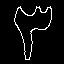

In [4]:
# Getting a random picture from our dataset
image_path = Path(train_dir)
images_path_list = list(image_path.glob('*/*.png'))
print(f'length of our dataset images (Train): {len(images_path_list)}')
random_img = random.choice(images_path_list)
img = Image.open(random_img)
img

## Data Transformations

The code defines a sequence of image transformations:

1. Grayscale conversion (removes color information).
2. Resize to 32x32 pixels (ensures uniform size).
3. Convert to PyTorch tensor (prepares for model input).

These transformations prepare images for a deep learning model, typically for classification tasks. 

In [5]:
transforms_simple = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32,32)),
    transforms.ToTensor()
])


## Creating Datasets

Prepares datasets for training and testing using `datasets.ImageFolder`:

- **Training (`train_data_folder`):** Loads images from `train_dir` and applies `transforms_simple` for pre-processing.
- **Testing (`test_data_folder`):** Loads images from `test_dir` with the same transformations.


In [6]:
train_data_folder = datasets.ImageFolder(train_dir,
                                         transform=transforms_simple
                                         )

test_data_folder = datasets.ImageFolder(test_dir,
                                        transform=transforms_simple)


Sets up `Dataloaders` for training and testing using PyTorch:

- **Batching:** `BATCH_SIZE` images are processed together (16 here) for efficiency.
- **Parallelism:** `NUM_WORKERS` CPU cores load data concurrently (utilizes all cores).
- **Shuffling:** Training data is shuffled for better generalization.
- **Class Information:** Class names (`data_classes`) and their corresponding indices (`classes_to_idx`) are stored.

Dataloaders streamline data loading, improving training and testing efficiency.


In [7]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data_folder,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data_folder,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [8]:
# Checking the shape of the train data
train_img, train_label = next(iter(train_dataloader))
train_img.shape, train_label.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

In [9]:
# Checking the number of bathces of each dataset (train and test)
len(train_dataloader), len(test_dataloader)

(2418, 606)

In [197]:
# Checking the data classes and mapping it to idx
data_classes = test_data_folder.classes
classes_to_idx = test_data_folder.class_to_idx
data_classes, classes_to_idx

(['ا',
  'ب',
  'ت',
  'ث',
  'ج',
  'ح',
  'خ',
  'د',
  'ذ',
  'ر',
  'ز',
  'س',
  'ش',
  'ص',
  'ض',
  'ط',
  'ظ',
  'ع',
  'غ',
  'ف',
  'ق',
  'ك',
  'ل',
  'لا',
  'م',
  'ن',
  'ه',
  'و',
  'ي',
  '٠',
  '١',
  '٢',
  '٣',
  '٤',
  '٥',
  '٦',
  '٧',
  '٨',
  '٩'],
 {'ا': 0,
  'ب': 1,
  'ت': 2,
  'ث': 3,
  'ج': 4,
  'ح': 5,
  'خ': 6,
  'د': 7,
  'ذ': 8,
  'ر': 9,
  'ز': 10,
  'س': 11,
  'ش': 12,
  'ص': 13,
  'ض': 14,
  'ط': 15,
  'ظ': 16,
  'ع': 17,
  'غ': 18,
  'ف': 19,
  'ق': 20,
  'ك': 21,
  'ل': 22,
  'لا': 23,
  'م': 24,
  'ن': 25,
  'ه': 26,
  'و': 27,
  'ي': 28,
  '٠': 29,
  '١': 30,
  '٢': 31,
  '٣': 32,
  '٤': 33,
  '٥': 34,
  '٦': 35,
  '٧': 36,
  '٨': 37,
  '٩': 38})

# Model Initialization

- Defines a simple CNN architecture (`Net`) with convolutional and fully-connected layers for image classification.
- The model takes grayscale images (1 channel) as input and outputs (class probabilities) based on 39 classes.
- An instance of the model is created and moved to the specified device (CPU or GPU) for computations.

In [20]:
# Model Architecture (simple cnn with 2 conv layers)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 39)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = Net().to(device)

## Loss Function & Optimizer

Define essential elements for training the model:

**Loss Function:**

* `loss_fn = nn.CrossEntropyLoss()`: Defines the loss function as cross-entropy for multi-class classification.

**Optimizer:**

* `optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)`: 
    - Uses Stochastic Gradient Descent (SGD) optimizer.
    - Sets the learning rate (`lr`) to 0.01.


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model.parameters(),
                             lr= 0.01)

# Train the model

 **Training and Testing Functions**

- **`train_step`:**
    - Trains model on a data batch.
    - Forward pass, loss calculation, backpropagation, parameter updates.
    - Tracks and returns average loss and accuracy.

- **`test_step`:**
    - Evaluates model on a data batch.
    - Forward pass, loss calculation, accuracy calculation.
    - No backpropagation, uses inference mode.
    - Tracks and returns average loss and accuracy.

- **`train`:**
    - Takes model, dataloaders, optimizer, loss function and epochs as input.
    - Tracks training/testing loss and accuracy in a dictionary.
    - Iterates through epochs, calling `train_step` and `test_step` for each epoch.
    - Prints training progress and updates the results dictionary.
    - Returns the dictionary containing the training history.



In [22]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # if batch % 50 == 0 or batch == len(train_dataloader):
        #     print(f'{batch*BATCH_SIZE} / {len(train_dataloader) * BATCH_SIZE}')

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [23]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [26]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [27]:
# train and save the result to plot it
model_results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0189 | train_acc: 0.1972 | test_loss: 0.8657 | test_acc: 0.7729
Epoch: 2 | train_loss: 0.4351 | train_acc: 0.8744 | test_loss: 0.2715 | test_acc: 0.9159
Epoch: 3 | train_loss: 0.1769 | train_acc: 0.9463 | test_loss: 0.1295 | test_acc: 0.9620
Epoch: 4 | train_loss: 0.1118 | train_acc: 0.9671 | test_loss: 0.0919 | test_acc: 0.9728
Epoch: 5 | train_loss: 0.0809 | train_acc: 0.9769 | test_loss: 0.0709 | test_acc: 0.9809
Epoch: 6 | train_loss: 0.0627 | train_acc: 0.9816 | test_loss: 0.0756 | test_acc: 0.9769
Epoch: 7 | train_loss: 0.0535 | train_acc: 0.9849 | test_loss: 0.0523 | test_acc: 0.9854
Epoch: 8 | train_loss: 0.0442 | train_acc: 0.9876 | test_loss: 0.0602 | test_acc: 0.9824
Epoch: 9 | train_loss: 0.0371 | train_acc: 0.9893 | test_loss: 0.0407 | test_acc: 0.9888
Epoch: 10 | train_loss: 0.0326 | train_acc: 0.9907 | test_loss: 0.0615 | test_acc: 0.9827


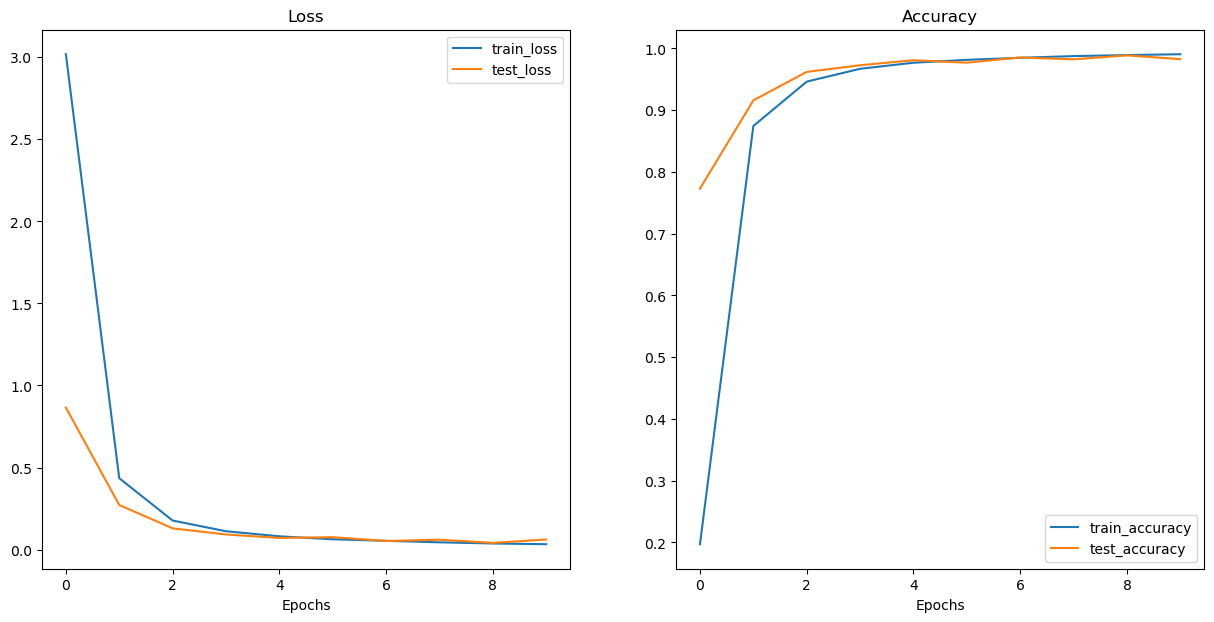

In [28]:
def plot_loss_curves(results: dict):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

`base64_to_image` function converts a base64 encoded file (our base64 img file) into a usable image format. It reads the file, decodes the base64 data, saves it as an image (e.g., `decoded.png`), and returns the image path.

In [188]:
# convert base64 to png
def base64_to_image(base64_file: base64) -> Path:
    """
    takes base64 file and convert it to png img

    parameters
    -------------
    base64_file : XX.bin file that we will convert
    
    returns
    -------------
    image_path : our image path
    """
    # string to image
    with open(base64_file, 'rb') as file:
        byte = file.read() 
    # Decode the Base64 string to binary data
    image_data = base64.b64decode(byte)
    # write the binary data to a png img
    image_path = 'decoded.png'
    with open(image_path, 'wb') as output_file:
        output_file.write(image_data)

    return image_path

In [206]:
def predict_on_base64(model: nn.Module, base64_file: base64) -> tuple:
    """
    Predicts the class label and its probability for a base64-encoded image.

    Parameters
    ----------
    model : torch.nn.Module The pre-trained CNN model used for prediction.

    base64_string : str The base64-encoded image data as a string.

    Returns
    -------
    tuple[str, float]
        A tuple containing the predicted class label (string) and its
        corresponding probability (float).
    """
    # Path of our img (after conversion)
    path = base64_to_image(base64_file)
    # Passing the image to convert it to float32 tensor
    custom_image = torchvision.io.read_image(str(path)).type(torch.float32)
    # Divide the image pixel values by 255 to get them between [0, 1]
    custom_image = custom_image / 255. 
    # Defining the same transforms for the image
    transform_img = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32,32)),
    ])
    # Transform target image
    custom_image_transformed = transform_img(custom_image)
    # Add an extra dimension to image -> [1, 1, 32, 32] -> [BATCH_SIZE, COLOR_CHANNELS, HEIGHT, WIDTH]
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    # Setting up the model for evaluation
    model.eval()
    with torch.inference_mode():
        # Make a prediction on image and returning the modeel logits
        custom_image_pred = model(custom_image_transformed_with_batch_size.to(device))
        # Getting the softamx of the logits to know the sample probability for the 39 classes
        prob = torch.softmax(custom_image_pred, dim=1)
        # Getting our image probability
        sample_prob = prob[0][prob.argmax()].item()
        # Getting the highes label index
        test_pred_labels = custom_image_pred.argmax(dim=1).item()
    # Model classes
    labels = data_classes
    # sample label
    test_pred_labels = labels[test_pred_labels]
    
    return test_pred_labels, sample_prob

In [207]:
prediction, probability = predict_on_base64(model=model, base64_file='encode.bin')
print(f"The prediction of the label is: {prediction} , with probability: {probability}")

The prediction of the label is: ٤ , with probability: 0.9997958540916443


## Saving the Model

In [208]:
# Defining the path of our model
path_of_model = 'cnn_net.pt'
# Save the model parameters to our path
torch.save(model.state_dict(), path_of_model)

## Loading and Testing the Model

In [219]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 39)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Load and send theee model to device (cpu or gpu)
loaded_model = Net().to(device)
# Loading the pretrained parameters to the model
loaded_model.load_state_dict(torch.load(path_of_model))
# setting up the model for evaluation
loaded_model.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=39, bias=True)
)

In [224]:
prediction, probability = predict_on_base64(model=loaded_model, base64_file='encode.bin')
print(f"The prediction of the label is: {prediction} , with probability: {probability}")

The prediction of the label is: ٤ , with probability: 1.0


# Draft Cells

In [18]:
def loads_data_classes():
    path = 'class_labels.txt'
    with open(path, 'r') as f:
        class_labels = [line.strip() for line in f]
    return class_labels

In [19]:
test = loads_data_classes()
test

['ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'لا',
 'م',
 'ن',
 'ه',
 'و',
 'ي',
 '٠',
 '١',
 '٢',
 '٣',
 '٤',
 '٥',
 '٦',
 '٧',
 '٨',
 '٩']

In [20]:
lst_labels = ['ا','ب','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','لا','م','ن','ه','و','ي','٠','١','٢','٣','٤','٥','٦','٧','٨','٩']

In [23]:
lst_labels[11]

'س'